# **Estimando la distribución de una variable aleatoria: el problema de la rana**

El *problema de la rana* dice lo siguiente: supongamos que hay una rana que siempre salta la misma distancia, y cada vez que salta lo hace aleatoriamente en cualquier dirección, entonces ¿cuál es la distribución de probabilidad de la distancia al origen después de $n$ saltos?

Asumimos que la rana salta en un plano, y que "aleatoriamente" quiere decir que la variable aleatoria que modela la dirección de salto sigue una distribución uniforme. Entonces es fácil de ver que la variable aleatoria que define la distancia tras $n$ saltos viene dada por

$$
Y_n=\left|\sum_{k=1}^n e^{i X_k}\right|=\sqrt{n+2\sum_{1\le j< k\le n}\cos (X_j-X_k)}\tag{1}
$$

donde cada $X_k$ es independiente de las otras y todas tienen una distribución uniforme en $[0,2\pi]$. Dos formas de atacar el problema: a través de una aproximación analítica o con una simulación con números pseudo-aleatorios.

## 1. Aproximación analítica

A partir de $n\ge 3$ se hace complicado calcular explícitamente la función de densidad de $Y_n$, así que en principio nos tendríamos que contentar con una aproximación teórica. Para esto podemos utilizar el [teorema del límite central para vectores aleatorios](https://en.wikipedia.org/wiki/Central_limit_theorem#Multidimensional_CLT) (TLC de ahora en adelante), ya que $V_k:=(\cos(X_j),\sin(X_j))\equiv e^{ i X_j}$. Entonces si la varianza de cada componente de $V_k$ es finita y $E[V_k]=\mu$ (que en nuestro caso es cero) tenemos que

$$
\frac1{\sqrt n}\left(\sum_{k=1}^n V_k-\mu\right)\overset{\text{distribución}}{\longrightarrow}N_2,\quad\text{ cuando }n\to\infty\tag{2}
$$

donde $N_2$ es una variable aleatoria con distribución bi-normal de media cero y matriz de covarianza igual a la de cada $V_k$. Y por tanto

$$
\Pr[Y_n/\sqrt n\le d]\to\frac1{2\pi}\int_{d\Bbb D} e^{-(x^2+y^2)}d(x,y)=\frac1{2\pi}\int_0^{2\pi}\int_0^d r e^{-r^2}dr\, d\theta=1-e^{-d^2},\quad\text{conforme }n\to\infty\tag{3}
$$

que nos deja finalmente la aproximación $F_{Y_n}(x)\approx 1-e^{-x^2/n}$ para $n$ suficientemente grande. Como dato adicional decir que, si lo necesitásemos, sería posible estimar el error de esta aproximación a través de la [desigualdad de Berry Esseen](https://en.wikipedia.org/wiki/Berry%E2%80%93Esseen_theorem).

## 2. Muestra simulada y posterior estimación

Haremos una simulación con el lenguaje de programación Julia y las librerías [`KernelDensity`](https://github.com/JuliaStats/KernelDensity.jl), que nos estima la función de densidad de una matriz de datos dada, y [`Plots`](https://github.com/JuliaPlots/Plots.jl/), con la que más tarde haremos los gráficos. 

La función `rand()` devuelve un número entre cero y uno de una sucesión de números que tiene propiedades semejantes a una sucesión realmente aleatoria con distribución uniforme en $[0,1)$, y cada vez que se llama a esta función da el número siguiente en la sucesión. A los generadores de estas sucesiones se les llama *generadores de números pseudo-aleatorios* (o también llamados generadores de números aleatorios sin más, ya que se sobreentiende en el contexto que no son verdaderos números aleatorios) y hay mucha bibliografía sobre ellos analizando sus propiedades e idoneidad a la hora de simular aleatoriedad para un experimento dado. En nuestro caso el generador de números (pseudo) aleatorios que utiliza Julia por defecto es más que suficiente para nuestra simulación.

El siguiente código define una función `rd` que simula la distancia recorrida tras $n$ saltos aleatorios

In [1]:
function rd(n::Int)
    p = 1.0 # el primer salto
    for j in 2:n
        p += exp(2pi * im * rand())
    end
    return abs(p)
end;

A partir de la función anterior generamos un vector que contenga un número elevado de experimentos aleatorios, lo hacemos con la siguiente función

In [2]:
function sim(n::Int, m::Int = 22)
    datos = zeros(2^m) # vector cero de longitud 2^m
    for i in 1:2^m
        datos[i] = rd(n) # llenamos el vector con distancias aleatorias simuladas
    end
    return datos
end;

La función anterior se ejecuta como `sim(n)` o como `sim(n,m)`, donde `n` representa el número de saltos y `m` es un parámetro opcional que define el número de experimentos aleatorios a realizar, es decir el tamaño de la muestra (por defecto el número de experimentos a realizar es $2^{22}\approx 4\cdot 10^6$).

Entonces procederíamos a hacer una estimación de la función de densidad de $Y_n$, en este caso la librería `KernelDensity` realiza una estimación no-paramétrica de la densidad en cada punto, denominada en la literatura como KDE ([kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation)), que en nuestro caso toma la forma

$$
{\hat f_{Y_n}}(x;h)=\frac1{N h}\sum_{k=1}^N K\left(\frac{x-x_k}{h}\right)\tag{4}
$$

donde $h$ se denomina *ancho de banda* y es un parámetro que depende de la muestra y de suma importancia para la correcta estimación de la función de densidad; $N$ es el tamaño de la muestra (en nuestro programa tendríamos que $N=2^m$); y $x_k$ es cada muestra (en nuestro programa cada coordenada del vector `sim(n,m)`). Por último $K$ es una función de densidad simétrica, con media cero y varianza finita, denominada el núcleo o *kernel* de la estimación, que lo que hace es valorar el peso de cada punto $x_k$ para la estimación de la densidad en $x$. Es común elegir para $K$ el [núcleo gaussiano](https://en.wikipedia.org/wiki/Gaussian_function).

## 3. Graficación

El siguiente código define una función que grafica las funciones de densidad o las distribuciones de probabilidad, y permite comparar las funciones estimadas con el método KDE o con el TLC.

El núcleo por defecto que utiliza la librería `KernelDensity` para estimar la densidad es el gaussiano, y un valor apropiado de ancho de banda para la muestra dada es definido por un algoritmo.

In [3]:
using KernelDensity, Plots
function p1(n::Int, m::Int= 22; cdf::Int = -1, c::Symbol = :auto)
    r = 0:n/100:n # dominio
    k = kde(sim(n,m)) # PDF estimada del vector sim(n,m) por el método KDE
    x = pdf(k,r) # imagen de la densidad en cada punto del dominio
    cdf <= 0 && begin
        p = plot!(r, x, color = c,
            xlabel = "Distancia",
            label = "PDF de $n saltos estimada por KDE")
        f(y) = 2y*exp(-y^2/n)/n # PDF aproximada con el TLC
        p = plot!(f, 0, n, l = :dash, w = 3, color = c,
            label = "PDF de $n saltos estimada por el TLC")
        end
    cdf >= 0 && begin
        cdfx = cumsum(x)/sum(x) # imagen de la CDF estimada por KDE
        p = plot!(r, cdfx, color = c,
            label = "CDF de $n saltos estimada por KDE",
            xlabel = "Distancia",
            ylabel = "Probabilidad")
        g(y) = 1- exp(-y^2/n) # CDF estimada con el TLC
        p = plot!(g, 0, n, l = :dash, w = 3, color = c,
            label = "CDF de $n saltos estimada por el TLC")
        end
return p
end;

Cada vez que llamamos a la función `p1` ésta añade una gráfica más sobre el mismo lienzo, los parámetros `m` y `c` son opcionales, el primero (al igual que antes) controla la cantidad de experimentos sobre la que hacer las estimaciones, y el segundo [la paleta de colores a usar](https://docs.juliaplots.org/latest/colors/). Un ejemplo

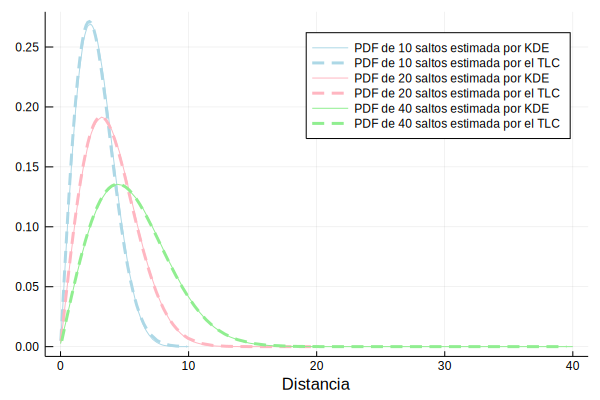

In [4]:
p1(10, c=:blues); p1(20, c=:reds); p1(40, c=:greens)

Y con la misma función podemos dibujar las distribuciones de probabilidad, añadiendo la opción `cdf = 1`

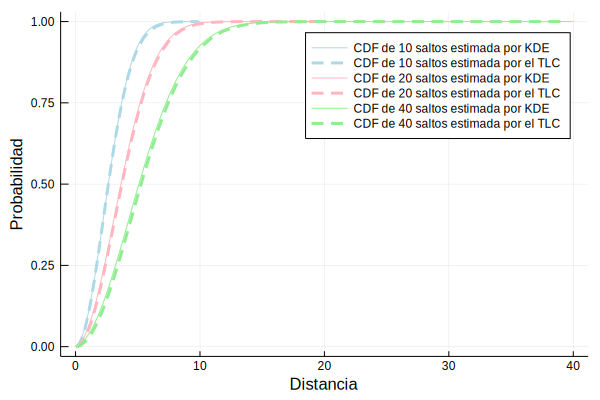

In [5]:
plot(); # Reseteamos el lienzo para empezar a graficar en uno nuevo
p1(10, c=:blues, cdf = 1); p1(20, c=:reds, cdf = 1); p1(40, c=:greens, cdf = 1)